In [1]:
%load_ext autoreload
%autoreload 2

# Open3D Data PreProcessing

In [2]:
import copy
from lib.render.camera import Camera
import torch
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import KDTree
from pathlib import Path
from lib.data.metainfo import MetaInfo

o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)


def visualize(obj):
    o3d.visualization.draw_plotly([obj], up=[0, 1, 0], front=[0.1, 0.1, -0.1])

def visualize_cloud(points, sdfs):
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(points)
    color = np.zeros_like(points)
    color[sdfs > 0 , 0] = 1
    color[sdfs < 0 , 2] = 1
    cloud.colors = o3d.utility.Vector3dVector(color)
    visualize(cloud)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


# Normal Map

## Load And Normalize

In [61]:
metainfo = MetaInfo(data_dir="/home/borth/sketch2shape/data/shapenet_chair_10")
obj_id = metainfo.obj_ids[5]
mesh = metainfo.load_mesh(obj_id=obj_id, file_name="mesh.obj", normalize=True)
visualize(mesh)

## Sphere Tracing and Normals Map

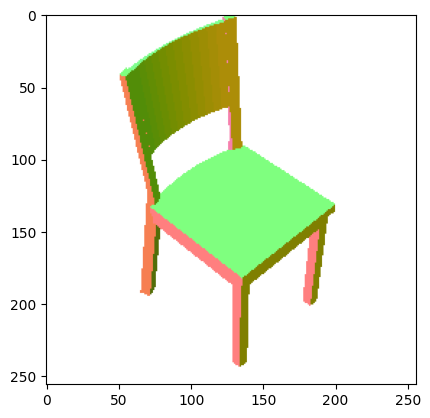

In [64]:
def normals_to_image(normals: np.ndarray, mask, width: int = 256, height: int = 256):
    normals = (normals + 1) / 2
    normals[~mask] = 1
    return normals.reshape(width, height, -1)


def render_normals(
    mesh: o3d.geometry.TriangleMesh,
    azims=[0, 1, 1],  # start, end, stop
    elevs=[0, 1, 1],  # start, end, stop
):
    assert len(azims) == 3
    azim_start, azim_end, azim_step = azims
    assert len(elevs) == 3
    elev_start, elev_end, elev_step = elevs

    _mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
    scene = o3d.t.geometry.RaycastingScene()
    _ = scene.add_triangles(_mesh)

    _points = []
    _normals = []
    _masks = []
    for azim in np.arange(azim_start, azim_end, azim_step):
        for elev in np.arange(elev_start, elev_end, elev_step):
            camera = Camera(azim=azim, elev=elev)
            points, rays, _ = camera.unit_sphere_intersection_rays()

            # sphere tracing
            camera_rays = np.concatenate([points, rays], axis=-1)
            out = scene.cast_rays(camera_rays)

            # noramls map
            t_hit = out["t_hit"].numpy()
            mask = t_hit != np.inf
            t_hit[~mask] = 0

            # correct normals
            normals = out["primitive_normals"].numpy()
            outside_mask = (normals * rays).sum(axis=-1) > 0
            normals[outside_mask] = -normals[outside_mask]

            # update the points
            points = points + t_hit[..., None] * rays

            _points.append(points)
            _normals.append(normals)
            _masks.append(mask)

    return np.stack(_points), np.stack(_normals), np.stack(_masks)


azim, elev = 45, -45
points, normals, masks = render_normals(
    mesh=mesh,
    azims=[azim, azim + 1, 1],
    elevs=[elev, elev + 1, 1],
)

normals = normals_to_image(normals[0], masks[0])
plt.imshow(normals)

# Sample SDF 

In [ ]:
from dataclasses import dataclass

@dataclass
class SDF:
    # base samples
    mesh: o3d.geometry.TriangleMesh
    azims = [0, 360, 30]  # start, end, stop
    elevs = [-90, 90, 30]  # start, end, stop
    cloud_samples: int = 500000
    # sample surface points
    surface_samples: int = 50000
    # sample inside points
    inside_samples: int = 150000
    inside_buffer_multiplier: float = 1.2
    inside_delta_mean: float = 0.0
    inside_delta_var: float = 1e-02
    # sample outside points
    outside_samples: int = 250000
    outside_buffer_multiplier: float = 1.2
    outside_delta_mean: float = 0.0
    outside_delta_var: float = 5e-02
    # sample unit sphere points
    unit_samples: int = 50000
    unit_buffer_multiplier: float = 1.2
    unit_alpha: float = 2.0
    unit_beta: float = 0.5

    def __post_init__(self):
        points, normals, masks = render_normals(
            mesh=mesh,
            azims=self.azims,
            elevs=self.elevs,
        )
        self.cloud_points, self.cloud_normals  = points[masks], normals[masks]
        self.tree = KDTree(self.cloud_points, leaf_size=2)

    def _get_cloud_samples(self, num_samples: int):
        mask = np.random.choice(self.cloud_points.shape[0], num_samples)
        return self.cloud_points[mask], self.cloud_normals[mask]

    def _get_sdfs(self, query: np.ndarray):
        sdfs, idx = self.tree.query(query, k=1)
        nearest_point = self.cloud_points[idx.squeeze()]
        nearest_normal = self.cloud_normals[idx.squeeze()]
        inside_mask = np.sum((query - nearest_point) * nearest_normal, axis=-1) < 0
        sdfs[inside_mask] = -sdfs[inside_mask]
        return sdfs.squeeze()

    def _sample_surface(self, num_samples: int):
        points, _ = self._get_cloud_samples(num_samples)
        sdfs = np.zeros(points.shape[0])
        return points, sdfs

    def _sample_near_surface(
        self,
        num_samples: int = 10000,
        inside_surface: bool = True,
        buffer_multiplier: float = 1.0,
        delta_mean: float = 0.0,
        delta_var: float = 5e-02,
    ):
        assert buffer_multiplier >= 1.0
        num_query_samples = int(num_samples * buffer_multiplier)
        delta = np.abs(np.random.normal(delta_mean, delta_var, size=num_query_samples))
        if inside_surface:
            delta = -delta

        points, normals = self._get_cloud_samples(num_query_samples)
        points = points + normals * delta[..., None]
        sdfs = self._get_sdfs(query=points)

        valid_mask = sdfs < 0 if inside_surface else sdfs > 0
        valid_mask &= np.linalg.norm(points, axis=-1) <= 1.0

        points, sdfs = points[valid_mask], sdfs[valid_mask]

        # ensures that you have the required points and sdfs with recursion
        if sdfs.shape[0] < num_samples:
            print("WARNING: buffer_multiplier to low. TODO change to logger!")
            points, sdfs = self._sample_near_surface(
                num_samples=num_samples,
                inside_surface=inside_surface,
                buffer_multiplier=buffer_multiplier * 2,
                delta_mean=delta_mean,
                delta_var=delta_var,
            )

        final_mask = np.random.choice(points.shape[0], num_samples)
        return points[final_mask], sdfs[final_mask]

    def _sample_unit_ball(
        self,
        num_samples: int = 100000,
        buffer_multiplier: float = 1.2,
        alpha: float = 2.0,
        beta: float = 0.5,
    ):
        assert buffer_multiplier >= 1.0
        num_query_samples = int(num_samples * buffer_multiplier)
        circle = o3d.geometry.TriangleMesh.create_sphere()
        point_cloud = circle.sample_points_uniformly(number_of_points=num_query_samples)

        points = np.asarray(point_cloud.points)
        points = points / np.linalg.norm(points, axis=-1)[..., None]

        radius = np.random.beta(alpha, beta, points.shape[0])
        points = points * radius[..., None]

        sdfs = self._get_sdfs(points)
        outside_mask = sdfs > 0
        points, sdfs = points[outside_mask], sdfs[outside_mask]

        if points.shape[0] < num_samples:
            print("WARNING: buffer_multiplier to low. TODO change to logger!")
            points, sdfs = self._sample_unit_ball(
                num_samples=num_samples,
                buffer_multiplier=buffer_multiplier * 2,
                alpha=alpha,
                beta=beta,
            )

        final_mask = np.random.choice(points.shape[0], num_samples)
        return points[final_mask], sdfs[final_mask]

    def sample_surface(self):
        return self._sample_surface(num_samples=self.surface_samples)

    def sample_inside_surface(self):
        return self._sample_near_surface(
            num_samples=self.inside_samples,
            inside_surface=True,
            buffer_multiplier=self.inside_buffer_multiplier,
            delta_mean=self.inside_delta_mean,
            delta_var=self.inside_delta_var,
        )

    def sample_outside_surface(self):
        return self._sample_near_surface(
            num_samples=self.outside_samples,
            inside_surface=False,
            buffer_multiplier=self.outside_buffer_multiplier,
            delta_mean=self.outside_delta_mean,
            delta_var=self.outside_delta_var,
        )
    
    def sample_unit_ball(self):
        return self._sample_unit_ball(
            num_samples=self.unit_samples,
            buffer_multiplier=self.unit_buffer_multiplier,
            alpha=self.unit_alpha,
            beta=self.unit_beta,
        )


sdf = SDF(mesh=mesh)
surface_points, surface_sdfs = sdf.sample_surface() 
unit_points, unit_sdfs = sdf.sample_unit_ball() 
inside_points, inside_sdfs = sdf.sample_inside_surface() 
outside_points, outside_sdfs = sdf.sample_outside_surface() 
points = np.concatenate([surface_points, unit_points, inside_points, outside_points])
sdfs = np.concatenate([surface_sdfs, unit_sdfs, inside_sdfs, outside_sdfs])
visualize_cloud(points, sdfs)

In [ ]:
x = np.load("/home/borth/sketch2shape/data/shapenet_chair_10/shapes/2c67f62020ca22927297db8481c2b16b/sdf_samples.npz")
pos = x["pos"]
neg = x["neg"]
points = np.concatenate([pos[:, :3], neg[:, :3]])
sdfs = np.concatenate([pos[:, 3], neg[:, 3]])
visualize_cloud(points, sdfs)